## FaceNet


Import section


In [2]:
import cv2 as cv
import os 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import MySQLdb
import numpy as np
import base64

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Testing the connection to database

In [4]:
# Load up the .env file
try:
    if (load_dotenv()):
        print("Loaded .env variables")
    else:
        print("Error in loading variables or file not found!")

except Exception:
    print("Error in loading .env file")
## Connect to database
host = os.environ.get("DB_HOST")
user = os.environ.get("DB_USER")
pw = os.environ.get("DB_PASS")
db_name = os.environ.get("DB_SCHEMA")
try:
    connection = MySQLdb.connect(host, user, pw, db_name)
    print("Successfully connected to ", db_name)
    connection.close()
except Exception:
    print("Error connecting!")

Loaded .env variables
Successfully connected to  heroku_9ee0e413f16e154


Creating the database instance

In [5]:
# Create an instance for the db and cursor
def getDBCursor():
    db = MySQLdb.connect(host, user, pw, db_name)
    cursor = db.cursor()
    return cursor

### Fetching all Facial Captures from the database

In [6]:
# Define a global variable to store all IMG bytearray and data
face_capture = []
face_img = []

# Face Entity and all Facts from the table 
face_id = []
tenant_id = []
tenant_name = []
face_status = []


def fetch_all_FaceCaptures():
    '''
        Begin making queries to the database and SELECT our FACE_IMG table
        where all facial captures are stored
    '''
    # Create a query to select all facial captures
    sql_fetch_faceCaptures = "SELECT * FROM FACE_IMG"
    cursor = getDBCursor()
    cursor.execute(sql_fetch_faceCaptures)
    # Fetch all data as rows
    rows = cursor.fetchall()

    # Iterate and assign data as to row
    for row in rows:
        face_id = row[0]
        tenant_id = row[1]
        tenant_name = row[2]
        face_status = row[3]
        face_capture = row[4]
        # Convert the face_capture column to a bytes-like object
        face_capture_bytes = bytearray(face_capture)
        # Use the cv.imdecode() function to decode the bytes-like object into an image
        face_img = cv.imdecode(np.frombuffer(face_capture_bytes, np.uint8), cv.IMREAD_COLOR)

        # Display some attribute data 
        print("==============================================================")
        print("Face ID: ", face_id)
        print("Tenant ID: ", tenant_id)
        print("Tenant Full Name: ", tenant_name)
        print("Status: ", face_status)
        print("Face IMG data: ", face_img)
        print(" ---> Type: ", type(face_img))
        print("==============================================================")

        # Render the image 
        try:
            # Convert image to PNG format and store it in a variable
            try: 
                # encoded_img = cv.imencode(".png", face_img)
                # print("Converting image to .png")
                # face_img_png = encoded_img.tobytes()
                # with open(f'out/{tenant_name}.png', 'wb') as f:
                #     # Decode the base64-encoded PNG data
                #     decoded_data = base64.b64decode(face_img_png)
                #     print(f"Saved PNG file: out/{tenant_name}.png")
                #     # Write the decoded data to the file stream
                #     f.write(decoded_data)
                cv.imwrite(f'out/{tenant_name}.png', face_img)
                print("All images are saved into out/")
            except:
                print("An error has occurred converting the image")
        except: 
            print("There was an error to rendering the image")

# Call the function to test it
fetch_all_FaceCaptures()

Face ID:  24
Tenant ID:  144
Tenant Full Name:  Cloyd Van Secuya
Status:  Authorized
Face IMG data:  [[[202 192 205]
  [200 190 203]
  [198 188 201]
  ...
  [209 196 212]
  [208 195 211]
  [207 194 210]]

 [[200 190 203]
  [199 189 202]
  [196 186 199]
  ...
  [209 196 212]
  [208 195 211]
  [208 195 211]]

 [[199 189 202]
  [197 187 200]
  [194 184 197]
  ...
  [208 195 211]
  [209 196 212]
  [209 196 212]]

 ...

 [[196 188 211]
  [196 188 211]
  [196 188 211]
  ...
  [203 186 200]
  [201 184 198]
  [200 183 197]]

 [[196 188 211]
  [196 188 211]
  [196 188 211]
  ...
  [201 184 198]
  [199 182 196]
  [197 180 194]]

 [[196 188 211]
  [196 188 211]
  [196 188 211]
  ...
  [199 182 196]
  [197 180 194]
  [195 178 192]]]
 ---> Type:  <class 'numpy.ndarray'>
All images are saved into out/
Face ID:  34
Tenant ID:  14
Tenant Full Name:  Chariz Valerie Secuya
Status:  Authorized
Face IMG data:  [[[66 71 70]
  [67 72 71]
  [67 72 71]
  ...
  [94 82 70]
  [95 83 71]
  [95 83 71]]

 [[66 71 7

### Using PyPlot to map image values

First, we need to collect all our .png files saved in the 'out' directory

In [7]:
# Define the path to the directory containing the PNG files
directory_path = '../out'

# Save all .png files into a dictionary 
save_png_files = {}

# Get a list of all the PNG files in the directory
png_files = [f for f in os.listdir(directory_path) if f.endswith('.png')]

# Loop through the list of PNG files and open each file using cv2.imread()
for filename in png_files:
    file_path = os.path.join(directory_path, filename)
    save_png_files[filename] = file_path


Check saved items

In [8]:
for items in save_png_files:
    print(items)

Chariz Valerie Secuya.png
Cloyd Van Secuya.png


Second, now we can initialize these values for plotting

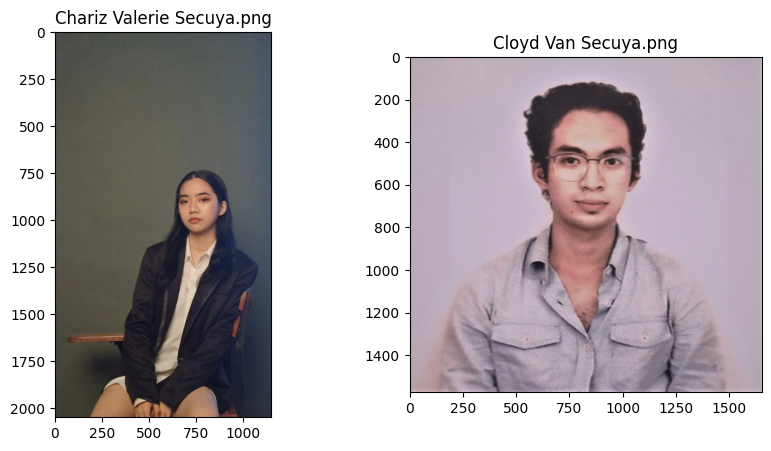

In [9]:
# Count the number of images
num_images = len(save_png_files)
# Set up the plot
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images*5,5))

for i, filename in enumerate(save_png_files):
    img_path = os.path.join(directory_path, filename)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)    # Set the images to RGB channel
    axes[i].imshow(img)
    axes[i].set_title(filename)
plt.show()

# 

### Facial Extraction

Import our MTCNN

In [10]:
from mtcnn.mtcnn import MTCNN

Initializing the face detection feature 

In [11]:
# Initialize the detector 
detector = MTCNN()
num_faces = 0
bounding_area = {}

for face in enumerate(save_png_files):
    img_path = os.path.join(directory_path, filename)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # Detect faces using MTCNN
    results = detector.detect_faces(img)
    num_faces = len(face)
    print("Bounding area: ", results)
    bounding_area[face] = results


1/1 [==============================] - 0s 154ms/step
Bounding area:  [{'box': [635, 263, 399, 555], 'confidence': 0.9996108412742615, 'keypoints': {'left_eye': (754, 491), 'right_eye': (943, 496), 'nose': (858, 606), 'mouth_left': (770, 689), 'mouth_right': (925, 697)}}]
1/1 [==============================] - 0s 31ms/step
Bounding area:  [{'box': [635, 263, 399, 555], 'confidence': 0.9996108412742615, 'keypoints': {'left_eye': (754, 491), 'right_eye': (943, 496), 'nose': (858, 606), 'mouth_left': (770, 689), 'mouth_right': (925, 697)}}]


### Initializing the bounding box

Try to get the results of the bounding area

In [12]:
bounding_area

{(0,
  'Chariz Valerie Secuya.png'): [{'box': [635, 263, 399, 555],
   'confidence': 0.9996108412742615,
   'keypoints': {'left_eye': (754, 491),
    'right_eye': (943, 496),
    'nose': (858, 606),
    'mouth_left': (770, 689),
    'mouth_right': (925, 697)}}],
 (1,
  'Cloyd Van Secuya.png'): [{'box': [635, 263, 399, 555],
   'confidence': 0.9996108412742615,
   'keypoints': {'left_eye': (754, 491),
    'right_eye': (943, 496),
    'nose': (858, 606),
    'mouth_left': (770, 689),
    'mouth_right': (925, 697)}}]}

Drawing a bounding box around the detected faces

1/1 [==============================] - 0s 33ms/step


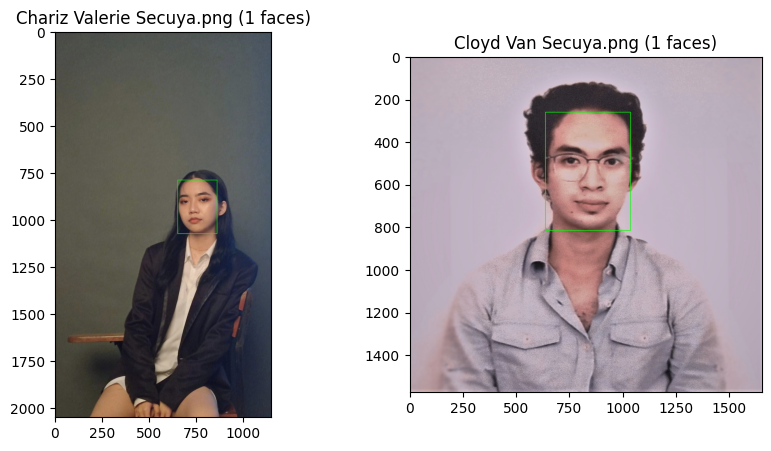

In [13]:
# Loop through the list of PNG files and display each image with detected faces using imshow
num_images = len(save_png_files)
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images*5,5))

for i, filename in enumerate(save_png_files):
    img_path = os.path.join(directory_path, filename)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Detect faces using MTCNN
    results = detector.detect_faces(img)
    num_faces = len(results)

    faces = []
    # Draw bounding boxes around the detected faces
    for j in range(num_faces):
        x, y, width, height = results[j]['box']
        face = img[y:y+height, x:x+width]
        faces.append(face)
        extracted_faces = np.array(faces)
        cv.rectangle(img, (x, y), (x+width, y+height), (0, 255, 0), 2)

    axes[i].imshow(img)
    axes[i].set_title(f"{filename} ({num_faces} faces)")

plt.show()


### Facial Extraction

In [14]:
for images in enumerate(save_png_files):
    img_path = os.path.join(directory_path, filename)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    results = detector.detect_faces(img)
    num_faces = len(results)

    # Store all detected areas
    detected_areas = {}

    # Then, create a list to store all
    bounding_box_x_y_w_h = [[]]

    for j in range(num_faces):
        x, y, width, height = results[j]['box']
        face = img[y:y+height, x:x+width]
        bounding_box_x_y_w_h.append(face)

for faces in save_png_files:
    # Store the bounding boxes for each face in a dictionary
    face_bounding_boxes = []
    for result in results:
        x, y, width, height = result['box']
        face_bounding_boxes.append((x, y, width, height))
        bounding_box_x_y_w_h.append(face_bounding_boxes)
    detected_areas[faces] = face_bounding_boxes

1/1 [==============================] - 0s 33ms/step


### Cropping face areas

In [15]:
# Initialize cropped_faces_img as an empty list
cropped_faces_img = []

# Loop through the images in save_png_files
for filename in save_png_files:
    img_path = os.path.join(directory_path, filename)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    results = detector.detect_faces(img)
    areas_to_crop = len(results)

    for j in range(areas_to_crop):
        x, y, width, height = results[j]['box']
        cropped_img = img[y:y+height, x:x+width]
        cropped_img = cv.resize(cropped_img, (160, 160))
        print("Shape: ", cropped_img.shape)

        # Append the cropped image to cropped_faces_img
        cropped_faces_img.append(cropped_img)


1/1 [==============================] - 0s 27ms/step
Shape:  (160, 160, 3)
1/1 [==============================] - 0s 29ms/step
Shape:  (160, 160, 3)


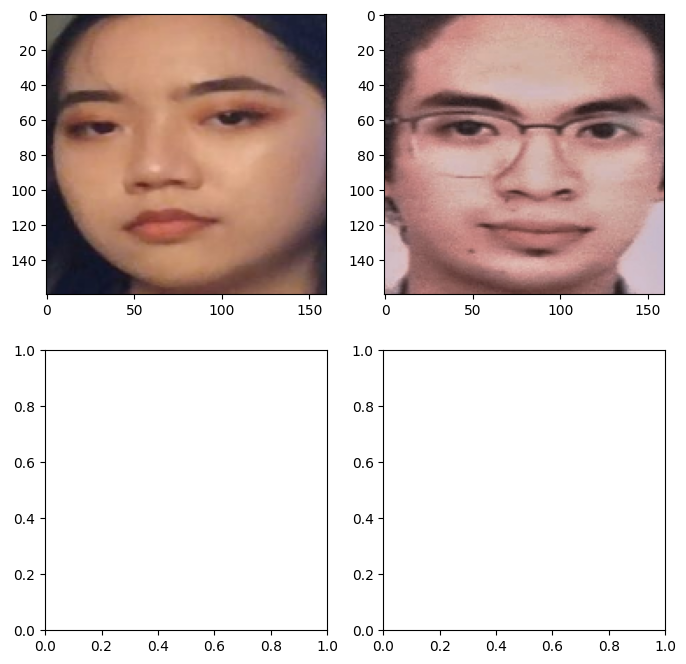

In [30]:
length_cropped_img = len(cropped_faces_img)
fig, axs = plt.subplots(nrows=length_cropped_img, ncols=2, figsize=(8, 8))
for i in range(length_cropped_img):
    row = i // 2
    col = i % 2
    axs[row, col].imshow(cropped_faces_img[i])
plt.show()
